In [1]:
import sys 

sys.path.append("./xebia_mower-0.1-py2.7.egg")

In [2]:
from __future__ import division
import pandas as pd
import seaborn
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import numpy as np

#Personal functions created for the project
from utils.clean_dataframe import DataFrameCleaner
from utils.prepare_features import FeaturePreparation
from utils.metrics import Metrics

seaborn.set_style("white")

# Data Analysis

In [3]:
dataframe_cleaner = DataFrameCleaner()
prepare_features = FeaturePreparation()

In [4]:
df = pd.read_csv("./Data/mower_market_snapshot.csv", sep=";")
validation_set = pd.read_csv("./Data/submission_set.csv", sep=";")
len(df)

1399

We first compare types of columns in the dataset, only to notice that production costs should be float64 but are strings

In [305]:
df.dtypes

capacity          float64
failure_rate      float64
id                  int64
margin            float64
price             float64
prod_cost          object
product_type       object
quality            object
warranty           object
market_share      float64
attractiveness    float64
dtype: object

In [306]:
validation_set.dtypes

capacity        float64
failure_rate    float64
id                int64
margin          float64
price           float64
prod_cost       float64
product_type     object
quality          object
warranty         object
dtype: object

In [307]:
#How many values of prod_cost are string ?
sum(df["prod_cost"] == "unknown")/len(df)

0.009292351679771264

### We decide to replace unknown values with zeros.

In [5]:
input_value = 0.

df["prod_cost"] = df["prod_cost"].apply(lambda s: float(s) if s != "unknown" else input_value)

Let's look at basic statistics for our dataset in order to determine if nothing is out of the ordinary.

In [49]:
df.describe()

,capacity,failure_rate,id,margin,price,prod_cost,attractiveness
count,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1381.000000,1399.000000
mean,47.663266,0.166448,18958.000000,186.262609,260.075165,54.912410,0.636507
std,19.840501,0.073605,404.000825,191.011102,259.949127,61.418106,0.124016
min,0.013884,0.028906,18259.000000,52.943989,62.162200,-64.000000,0.297384
25%,35.853890,0.095678,18608.500000,62.247602,73.379425,10.644263,0.549369
50%,50.309242,0.199796,18958.000000,66.299672,78.439753,12.104509,0.641351
75%,61.905015,0.228011,19307.500000,265.370973,384.265263,113.496210,0.726746
max,104.614865,0.302465,19657.000000,790.012898,964.973926,210.984941,0.952877


There are some negative production costs, but nothing else seems out of the ordinary. Margin is a proportion of price (if we accept the economic definition), are margins always less than prices ?

In [48]:
natural_prices = (validation_set["price"]-validation_set["margin"] >= 0)

validation_set[~natural_prices]

,capacity,failure_rate,id,margin,price,prod_cost,quality,warranty


In [6]:
natural_prices = (df["price"]-df["margin"] >= 0)

df[~natural_prices]

,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness
47,25.136228,0.044026,19549,618.616295,69.359766,0.0,auto-portee,Medium,3ans.,0.008874,0.907834
62,15.627623,0.041714,19448,657.152001,359.675157,-64.0,auto-portee,Low,3 ans,0.006839,0.699600
64,18.669448,0.036297,19368,738.279214,424.738557,0.0,auto-portee,Medium,3_ans.,0.007104,0.726770
100,28.029561,0.040033,18993,746.108663,350.216029,0.0,auto-portee,Hight,3anss,0.007847,0.802719
103,18.889544,0.036835,19194,661.693700,77.249896,-64.0,auto-portee,Low,3 ans,0.006655,0.680852
107,31.019904,0.038149,19522,658.116184,411.087712,NaN,auto-portee,Low,3 ans.,0.007505,0.767814
126,12.417808,0.037797,19638,672.153234,74.156037,0.0,auto-portee,Hight,3_ans,0.007923,0.810591
135,23.340049,0.039023,19596,726.196516,396.773981,NaN,auto-portee,Medium,3ans,0.006937,0.709674
166,39.703060,0.073723,18870,248.010000,70.271198,0.0,electrique,Low,2 ans,0.002607,0.679325
170,34.857361,0.114097,18964,241.552664,72.970497,NaN,electrique,Low,2 anss,0.003039,0.791921


It appears that it is not always the case which is peculiar, in the absence of a context it is difficult to determine why but it is worth noting that these mowers also have strange production costs. Plus this does not happen in the validation set, which might worsen our predictions.

In [5]:
df[[col for col in df.columns if col != "id"]].corr()

,capacity,failure_rate,margin,price,prod_cost,market_share,attractiveness
capacity,1.000000,0.623566,-0.642156,-0.567528,-0.609975,-0.565246,0.038534
failure_rate,0.623566,1.000000,-0.880764,-0.794297,-0.904262,-0.777919,-0.148860
margin,-0.642156,-0.880764,1.000000,0.869895,0.858342,0.948025,0.188124
price,-0.567528,-0.794297,0.869895,1.000000,0.799340,0.805629,0.142830
prod_cost,-0.609975,-0.904262,0.858342,0.799340,1.000000,0.755678,0.127906
market_share,-0.565246,-0.777919,0.948025,0.805629,0.755678,1.000000,0.415520
attractiveness,0.038534,-0.148860,0.188124,0.142830,0.127906,0.415520,1.000000


Populating the interactive namespace from numpy and matplotlib


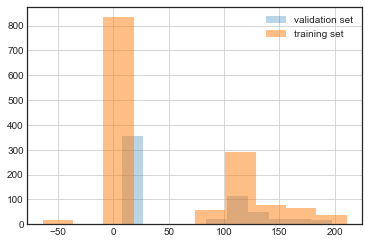

In [4]:
#I am suspicious about negative production costs it could be an error of imputation, I want to look at the distribution of prod_cost
%pylab inline

validation_set["prod_cost"].hist(alpha=.3)
df["prod_cost"].hist(alpha=.5)

plt.legend(["validation set", "training set"])

We observe three distinct groups, it might be worth bucketizing this column, we will find out later. Plus we observe that no production costs are negative on the validation set. Besides, in what world are there no production costs ?

In [49]:
sum(df["prod_cost"] < 0) # Important : Validate that it is not an error

18

In [52]:
df.product_type.value_counts()

essence        844
electrique     413
auto-portee    142
Name: product_type, dtype: int64

In [53]:
df.quality.value_counts()

Low       971
Medium    295
Hight     133
Name: quality, dtype: int64

This column is imputed like garbage, we should recompute it, while making sure we do not lose predictive power. As odd as it might be this oddness could be used as a feature. But let's first compare with the submission set:

In [56]:
validation_set.warranty.value_counts()

1 an     355
2 ans    185
3 ans     60
Name: warranty, dtype: int64

Ok so this is just wrong coding..

### Let's fix warranty

In [6]:
df["warranty"] = df["warranty"].apply(lambda w: dataframe_cleaner.clean_warranty(w))

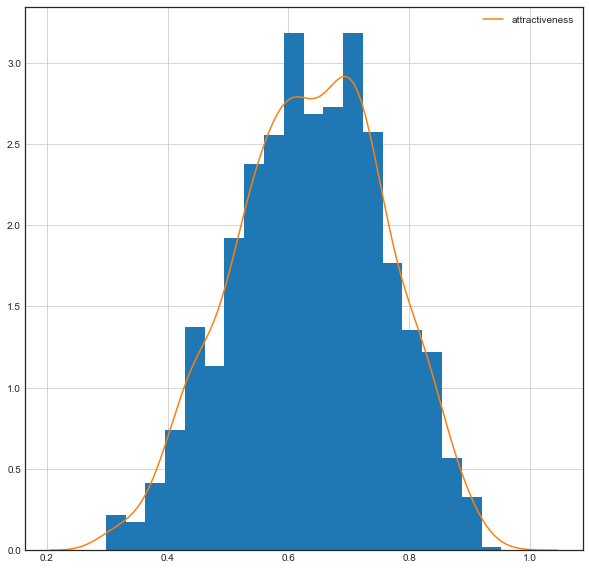

In [8]:
from seaborn import kdeplot

plt.figure(figsize=[10,10])
df["attractiveness"].hist(bins=20, normed=True)
kdeplot(df.attractiveness)

The variable seems to have approximately a normal distribution, so we might be good to go using a linear regression and have difficulties improving our predictions. 

In [310]:
print df.product_type.value_counts()
print df.warranty.value_counts()

essence        844
electrique     413
auto-portee    142
Name: product_type, dtype: int64
1 an     844
2 ans    413
3 ans    142
Name: warranty, dtype: int64


It looks like warranty and product types are identical. We can guess that each product type has a specific warranty, let's find out:

In [34]:
(all(df.groupby("product_type").get_group("auto-portee")["warranty"] == "3 ans")
&all(df.groupby("product_type").get_group("electrique")["warranty"] == "2 ans")
&all(df.groupby("product_type").get_group("essence")["warranty"] == "1 an"))

True

In [35]:
(all(validation_set.groupby("product_type").get_group("auto-portee")["warranty"] == "3 ans")
&all(validation_set.groupby("product_type").get_group("electrique")["warranty"] == "2 ans")
&all(validation_set.groupby("product_type").get_group("essence")["warranty"] == "1 an"))

True

Our Hypothesis is validated let's drop this column, we also drop market share since it is not present in the validation set.

### Dropping Unnecessary Columns

In [7]:
df = dataframe_cleaner.drop_columns(df)
validation_set = dataframe_cleaner.drop_columns(validation_set, True)

# Feature Preparation

In [8]:
X, y = prepare_features.separate_num_cat_target(df)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

## First Model

In [10]:
rmsle = Metrics().rmsle

Let's start with a baseline: for each y in the holdout set we will predict the average of the train set and measure our error. In some sense it is a first response, incomplete but it will allow us to have a better understanding of what type of results we could hope for.

In [313]:
rmsle(y_test, np.ones(len(y_test))*y_train.mean())

0.07536520551769196

In [82]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Yikes, we did not verify there was no null production costs... We need some inputation for this column, but it would be too strange to input 0 as the value. Hypothesis : Since production cost are very correlated with the other features, a 1-nearest neighbour approach for inputation might reflect reality.

In [11]:
null_prod_costs = (df.prod_cost.isna())
cols = [col for col in X.columns if col != "prod_cost"]
df[null_prod_costs].__len__()

18

In [12]:
null_imputer = prepare_features.null_imputer

In [13]:
null_imputer(X, null_prod_costs, 1).predict(X[null_prod_costs][cols])

array([-64.,   0.,   0., -64.,   0., -64.,   0., -64.,   0.,   0., -64.,
         0., -64., -64.,   0., -64.,   0., -64.])

When looking at the prediction, we realize that the neighbours of our null values are the strange points we already encountered production costs that are equal or inferior to zero. Decision : For the time being, try 8-knn but with all the strange values.

In [33]:
from sklearn.neighbors import KNeighborsRegressor

cols = [col for col in X.columns if col != "prod_cost"]
null_prod_costs = (df.prod_cost.isna()) | (df.prod_cost <=0)
null_predictor = null_imputer(X, null_prod_costs, 8)

In [34]:
predictions = null_predictor.predict(X[null_prod_costs][cols])
train_predictions = null_predictor.predict(X[~null_prod_costs][cols])
predictions

array([ 81.75251996, 104.88821655, 143.28689361, 112.96643214,
        84.63043129, 108.96566639,  84.63043129, 141.17373476,
       172.92917292, 172.92917292,  11.99508972,  11.69605408,
        11.69605408, 172.92917292,  11.99508972, 172.92917292,
       172.92917292, 172.92917292,  11.69605408, 172.92917292,
        11.99508972,  11.99508972, 150.63516713,  11.69605408,
       172.92917292,  11.99508972, 125.03949817, 145.32280405,
       141.09899754, 141.09899754, 142.95507711, 125.03949817,
       125.03949817, 125.03949817, 125.03949817, 141.09899754,
       142.95507711, 126.12722946, 141.09899754, 141.09899754,
       141.09899754, 142.95507711, 141.09899754, 141.09899754,
       141.09899754, 126.12722946, 125.03949817, 141.09899754,
       125.03949817, 141.09899754, 126.12722946, 122.59838519,
       141.09899754, 125.03949817, 122.59838519, 142.95507711,
       141.09899754, 141.09899754, 125.03949817, 142.95507711,
       125.18263815, 126.12722946, 141.09899754, 141.09

In [73]:
rmsle(train_predictions, X[~null_prod_costs]["prod_cost"])

0.05653949753997338

We will keep this model only if it does better than the model where prod_cost = 0 for strange values. We checked that there are no strange values in the validation set, so we might be introducing artificial bias, but we cannot know without a good explanation of why these values are strange. Another solution would be to learn a model on the validation set and apply it to the strange values in the training set, but that would just be cheating and would be detrimental to the generalization power of the model.

# Second model : with 0 inputation

In [29]:
X_0 = X.copy()
X_0["prod_cost"] =  X_0["prod_cost"].apply(lambda x: x if x > 0 and (x is not np.nan) else 0)

In [30]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0,y, test_size=.3, random_state=1000)

In [31]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_0_train, y_0_train)

print rmsle(reg.predict(X_0_test), y_0_test)

0.06795086392671441


# Second model : with knn inputation

In [14]:
input_knn = prepare_features.input_knn

X_k = X

null_prod_costs = (df.prod_cost.isna()) | (df.prod_cost <=0)
X_k["prod_cost"] = input_knn(X_k, X_k[["prod_cost"]], null_prod_costs, 8)

In [27]:
X_k[null_prod_costs]["prod_cost"].head()

47      81.752520
62     104.888217
64     143.286894
100    112.966432
103     84.630431
Name: prod_cost, dtype: float64

In [33]:
X_k_train, X_k_test, y_k_train, y_k_test = train_test_split(X_k,y, test_size=.3, random_state=1000)

In [34]:
from sklearn.linear_model import LinearRegression

l_reg = LinearRegression()

l_reg.fit(X_k_train, y_k_train)

print rmsle(l_reg.predict(X_k_test), y_k_test)

0.06795086392671441


We slightly improved our prediction without complicating the model too much so let's keep knn we are doing slightly better than always predicting the mean. We will now try different models. Let's look at our predictions :

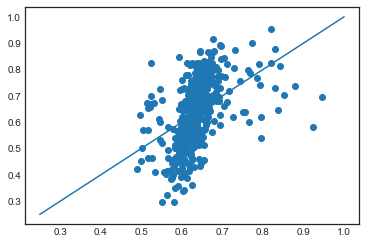

In [80]:
import matplotlib.pyplot as plt

plt.scatter(l_reg.predict(X_k_test), y_k_test)
plt.plot(np.linspace(.25,1,len(y_k_test)), np.linspace(.25,1,len(y_k_test)))

Our model is always predicting values around the average value we might need a better model.

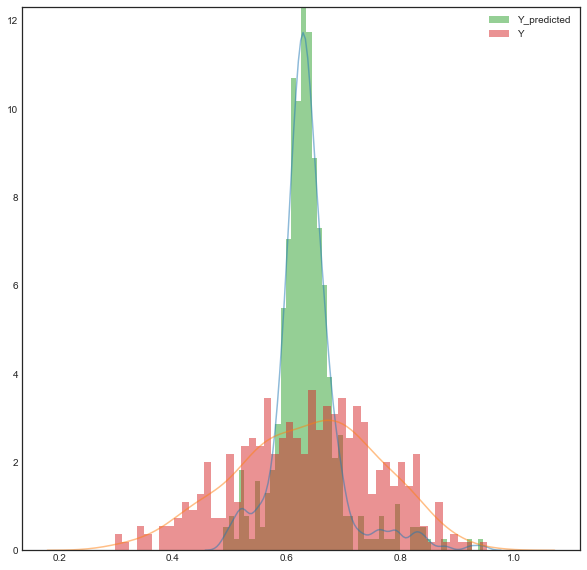

In [81]:
plt.figure(figsize=[10,10])

kdeplot(l_reg.predict(X_k_test), alpha=.5)
kdeplot(y_k_test.values,alpha=.5)

plt.hist(l_reg.predict(X_k_test), alpha=.5, normed=True,bins=50)
plt.hist(y_k_test,alpha=.5, normed=True,bins=50)
plt.legend(["Y_predicted", "Y"])

# Different models

## ElasticNet

In [36]:
from sklearn.linear_model import ElasticNetCV

e_reg = ElasticNetCV([.1,.3,.5,.6,.7,.8,.9,1.], cv=17, normalize=True,n_jobs=-1, random_state=1000)

e_reg.fit(X_k_train, np.log(1+y_k_train))

print rmsle(np.exp(e_reg.predict(X_k_test))-1, y_k_test)

0.06820595219255794


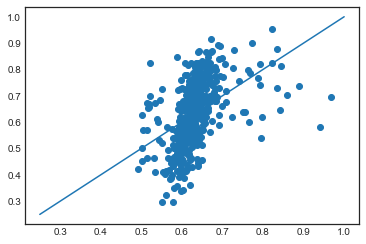

In [85]:
import matplotlib.pyplot as plt

plt.scatter(np.exp(e_reg.predict(X_k_test))-1, y_k_test)
plt.plot(np.linspace(.25,1,len(y_k_test)), np.linspace(.25,1,len(y_k_test)))

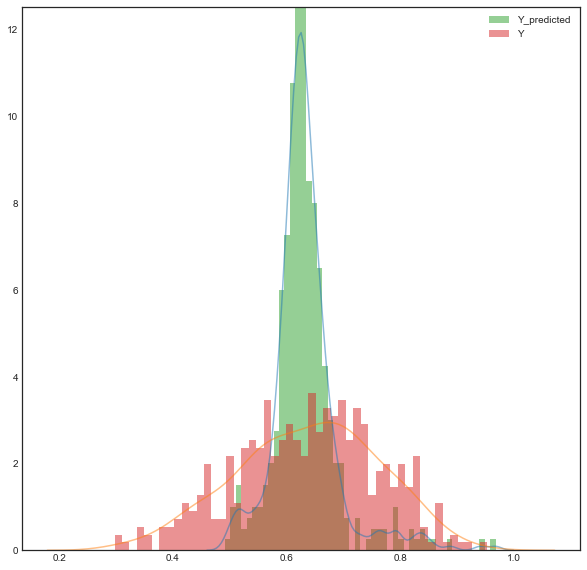

In [86]:
plt.figure(figsize=[10,10])

kdeplot(np.exp(e_reg.predict(X_k_test))-1, alpha=.5)
kdeplot(y_k_test.values,alpha=.5)

plt.hist(np.exp(e_reg.predict(X_k_test))-1, alpha=.5, normed=True,bins=50)
plt.hist(y_k_test,alpha=.5, normed=True,bins=50)
plt.legend(["Y_predicted", "Y"])

Elastic Net is doing worse than classical linear regression.

## Gradient Boosted Trees

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

g_reg_0 = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=.05)
g_reg_k = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=.05)

g_reg_0 = g_reg_0.fit(X_0_train, np.log(1+y_0_train))

g_reg_k = g_reg_k.fit(X_k_train, np.log(1+y_k_train))

print rmsle(np.exp(g_reg_0.predict(X_0_test))-1, y_0_test)
print rmsle(np.exp(g_reg_k.predict(X_k_test))-1, y_k_test)

0.045607111980572566
0.0456451237350371


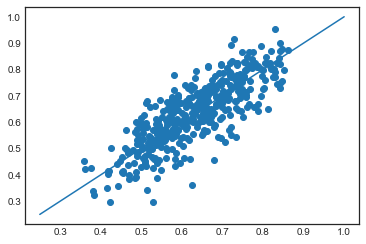

In [28]:
import matplotlib.pyplot as plt

plt.scatter(np.exp(g_reg.predict(X_0_test))-1, y_0_test)
plt.plot(np.linspace(.25,1,len(y_0_test)), np.linspace(.25,1,len(y_0_test)))

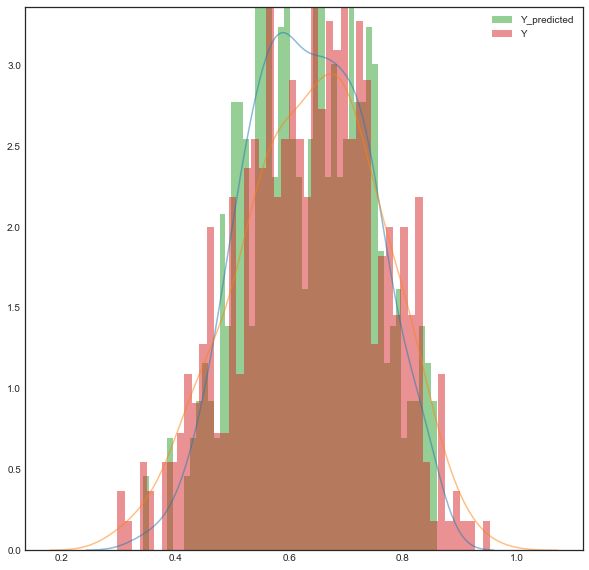

In [90]:
plt.figure(figsize=[10,10])

kdeplot(np.exp(g_reg.predict(X_k_test))-1, alpha=.5)
kdeplot(y_k_test.values,alpha=.5)

plt.hist(np.exp(g_reg.predict(X_k_test))-1, alpha=.5, normed=True,bins=50)
plt.hist(y_k_test,alpha=.5, normed=True,bins=50)
plt.legend(["Y_predicted", "Y"])

In [91]:
rmsle(.5*(np.exp(g_reg.predict(X_k_test))-1+l_reg.predict(X_k_test)), y_k_test)

0.05015703967198754

## Gaussian Process

The gaussian process is particularly adapted when working with few dimensions and few data points, let's test in this context.

In [44]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
gp_reg = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=15, kernel=Matern(), random_state=1000)

gp_reg.fit(X_k_train, np.log(1+y_k_train))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5),
             n_restarts_optimizer=15, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=1000)

In [45]:
rmsle(np.exp(gp_reg.predict(X_k_test))-1, y_k_test)

0.05908472871780649

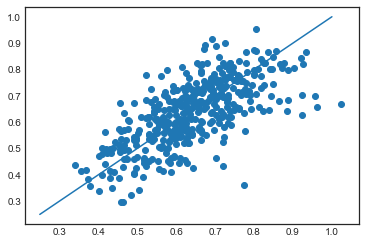

In [46]:
import matplotlib.pyplot as plt

plt.scatter(np.exp(gp_reg.predict(X_k_test))-1, y_k_test)
plt.plot(np.linspace(.25,1,len(y_k_test)), np.linspace(.25,1,len(y_k_test)))

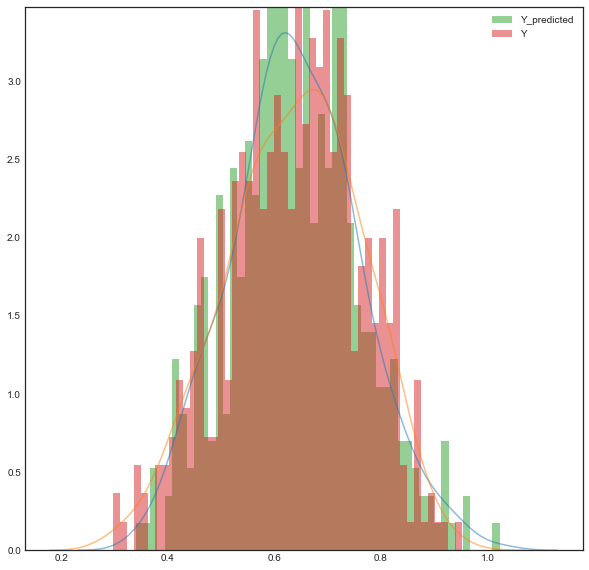

In [140]:
plt.figure(figsize=[10,10])

kdeplot(np.exp(gp_reg.predict(X_k_test))-1, alpha=.5)
kdeplot(y_k_test.values,alpha=.5)

plt.hist(np.exp(gp_reg.predict(X_k_test))-1, alpha=.5, normed=True,bins=50)
plt.hist(y_k_test,alpha=.5, normed=True,bins=50)
plt.legend(["Y_predicted", "Y"])

## Neural Network

Neural Networks are pretty popular these years, they need a lot of tweeking but thanks to recent advances in computer science they are no longer useful only when the number of observations is huge, let's try a simple Fully Connected network:

In [195]:
np.random.seed(0)
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.regularizers import l2

adam = Adam(lr=.0011)
model = Sequential()
model.add(Dense(48, input_dim=X_k.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_logarithmic_error',
              optimizer=adam,
              metrics=['mean_squared_logarithmic_error']
             )

fitter = model.fit(X_k_train.values, y_k_train.values, validation_data=[X_k_test.values,
                                                                                  y_k_test.values],
          epochs=400,
          batch_size=20)

Train on 979 samples, validate on 420 samples
Epoch 1/400
979/979 [==============================] - 1s 1ms/step - loss: 0.0295 - mean_squared_logarithmic_error: 0.0295 - val_loss: 0.0111 - val_mean_squared_logarithmic_error: 0.0111
Epoch 2/400
979/979 [==============================] - 0s 225us/step - loss: 0.0100 - mean_squared_logarithmic_error: 0.0100 - val_loss: 0.0071 - val_mean_squared_logarithmic_error: 0.0071
Epoch 3/400
979/979 [==============================] - 0s 243us/step - loss: 0.0077 - mean_squared_logarithmic_error: 0.0077 - val_loss: 0.0059 - val_mean_squared_logarithmic_error: 0.0059
Epoch 4/400
979/979 [==============================] - 0s 241us/step - loss: 0.0069 - mean_squared_logarithmic_error: 0.0069 - val_loss: 0.0056 - val_mean_squared_logarithmic_error: 0.0056
Epoch 5/400
979/979 [==============================] - 0s 245us/step - loss: 0.0068 - mean_squared_logarithmic_error: 0.0068 - val_loss: 0.0052 - val_mean_squared_logarithmic_error: 0.0052
Epoch 6/400

Epoch 44/400
979/979 [==============================] - 0s 238us/step - loss: 0.0049 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0048 - val_mean_squared_logarithmic_error: 0.0048
Epoch 45/400
979/979 [==============================] - 0s 233us/step - loss: 0.0049 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0047 - val_mean_squared_logarithmic_error: 0.0047
Epoch 46/400
979/979 [==============================] - 0s 222us/step - loss: 0.0050 - mean_squared_logarithmic_error: 0.0050 - val_loss: 0.0048 - val_mean_squared_logarithmic_error: 0.0048
Epoch 47/400
979/979 [==============================] - 0s 212us/step - loss: 0.0050 - mean_squared_logarithmic_error: 0.0050 - val_loss: 0.0047 - val_mean_squared_logarithmic_error: 0.0047
Epoch 48/400
979/979 [==============================] - 0s 219us/step - loss: 0.0049 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0050 - val_mean_squared_logarithmic_error: 0.0050
Epoch 49/400
979/979 [============================

979/979 [==============================] - 0s 235us/step - loss: 0.0046 - mean_squared_logarithmic_error: 0.0046 - val_loss: 0.0042 - val_mean_squared_logarithmic_error: 0.0042
Epoch 88/400
979/979 [==============================] - 0s 216us/step - loss: 0.0045 - mean_squared_logarithmic_error: 0.0045 - val_loss: 0.0041 - val_mean_squared_logarithmic_error: 0.0041
Epoch 89/400
979/979 [==============================] - 0s 210us/step - loss: 0.0047 - mean_squared_logarithmic_error: 0.0047 - val_loss: 0.0042 - val_mean_squared_logarithmic_error: 0.0042
Epoch 90/400
979/979 [==============================] - 0s 210us/step - loss: 0.0045 - mean_squared_logarithmic_error: 0.0045 - val_loss: 0.0040 - val_mean_squared_logarithmic_error: 0.0040
Epoch 91/400
979/979 [==============================] - 0s 227us/step - loss: 0.0044 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.0041 - val_mean_squared_logarithmic_error: 0.0041
Epoch 92/400
979/979 [==============================] - 0s 212u

979/979 [==============================] - 0s 232us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0039 - val_mean_squared_logarithmic_error: 0.0039
Epoch 131/400
979/979 [==============================] - 0s 234us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0040 - val_mean_squared_logarithmic_error: 0.0040
Epoch 132/400
979/979 [==============================] - 0s 243us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0040 - val_mean_squared_logarithmic_error: 0.0040
Epoch 133/400
979/979 [==============================] - 0s 241us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0037 - val_mean_squared_logarithmic_error: 0.0037
Epoch 134/400
979/979 [==============================] - 0s 251us/step - loss: 0.0044 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.0038 - val_mean_squared_logarithmic_error: 0.0038
Epoch 135/400
979/979 [==============================] - 0s

Epoch 173/400
979/979 [==============================] - 0s 226us/step - loss: 0.0042 - mean_squared_logarithmic_error: 0.0042 - val_loss: 0.0041 - val_mean_squared_logarithmic_error: 0.0041
Epoch 174/400
979/979 [==============================] - 0s 221us/step - loss: 0.0044 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.0040 - val_mean_squared_logarithmic_error: 0.0040
Epoch 175/400
979/979 [==============================] - 0s 211us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0039 - val_mean_squared_logarithmic_error: 0.0039
Epoch 176/400
979/979 [==============================] - 0s 244us/step - loss: 0.0044 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.0036 - val_mean_squared_logarithmic_error: 0.0036
Epoch 177/400
979/979 [==============================] - 0s 213us/step - loss: 0.0045 - mean_squared_logarithmic_error: 0.0045 - val_loss: 0.0039 - val_mean_squared_logarithmic_error: 0.0039
Epoch 178/400
979/979 [======================

Epoch 216/400
979/979 [==============================] - 0s 220us/step - loss: 0.0042 - mean_squared_logarithmic_error: 0.0042 - val_loss: 0.0046 - val_mean_squared_logarithmic_error: 0.0046
Epoch 217/400
979/979 [==============================] - 0s 208us/step - loss: 0.0044 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.0062 - val_mean_squared_logarithmic_error: 0.0062
Epoch 218/400
979/979 [==============================] - 0s 209us/step - loss: 0.0041 - mean_squared_logarithmic_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_logarithmic_error: 0.0039
Epoch 219/400
979/979 [==============================] - 0s 207us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_logarithmic_error: 0.0039
Epoch 220/400
979/979 [==============================] - 0s 209us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_logarithmic_error: 0.0039
Epoch 221/400
979/979 [======================

Epoch 259/400
979/979 [==============================] - 0s 220us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0034 - val_mean_squared_logarithmic_error: 0.0034
Epoch 260/400
979/979 [==============================] - 0s 231us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0033 - val_mean_squared_logarithmic_error: 0.0033
Epoch 261/400
979/979 [==============================] - 0s 227us/step - loss: 0.0041 - mean_squared_logarithmic_error: 0.0041 - val_loss: 0.0040 - val_mean_squared_logarithmic_error: 0.0040
Epoch 262/400
979/979 [==============================] - 0s 225us/step - loss: 0.0041 - mean_squared_logarithmic_error: 0.0041 - val_loss: 0.0047 - val_mean_squared_logarithmic_error: 0.0047
Epoch 263/400
979/979 [==============================] - 0s 231us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0036 - val_mean_squared_logarithmic_error: 0.0036
Epoch 264/400
979/979 [======================

Epoch 302/400
979/979 [==============================] - 0s 250us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0035 - val_mean_squared_logarithmic_error: 0.0035
Epoch 303/400
979/979 [==============================] - 0s 289us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0035 - val_mean_squared_logarithmic_error: 0.0035
Epoch 304/400
979/979 [==============================] - 0s 310us/step - loss: 0.0038 - mean_squared_logarithmic_error: 0.0038 - val_loss: 0.0041 - val_mean_squared_logarithmic_error: 0.0041
Epoch 305/400
979/979 [==============================] - 0s 320us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_logarithmic_error: 0.0038
Epoch 306/400
979/979 [==============================] - 0s 304us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0043 - val_mean_squared_logarithmic_error: 0.0043
Epoch 307/400
979/979 [======================

Epoch 345/400
979/979 [==============================] - 0s 324us/step - loss: 0.0041 - mean_squared_logarithmic_error: 0.0041 - val_loss: 0.0033 - val_mean_squared_logarithmic_error: 0.0033
Epoch 346/400
979/979 [==============================] - 0s 267us/step - loss: 0.0041 - mean_squared_logarithmic_error: 0.0041 - val_loss: 0.0034 - val_mean_squared_logarithmic_error: 0.0034
Epoch 347/400
979/979 [==============================] - 0s 261us/step - loss: 0.0040 - mean_squared_logarithmic_error: 0.0040 - val_loss: 0.0036 - val_mean_squared_logarithmic_error: 0.0036
Epoch 348/400
979/979 [==============================] - 0s 286us/step - loss: 0.0039 - mean_squared_logarithmic_error: 0.0039 - val_loss: 0.0035 - val_mean_squared_logarithmic_error: 0.0035
Epoch 349/400
979/979 [==============================] - 0s 278us/step - loss: 0.0039 - mean_squared_logarithmic_error: 0.0039 - val_loss: 0.0048 - val_mean_squared_logarithmic_error: 0.0048
Epoch 350/400
979/979 [======================

Epoch 388/400
979/979 [==============================] - 0s 233us/step - loss: 0.0037 - mean_squared_logarithmic_error: 0.0037 - val_loss: 0.0038 - val_mean_squared_logarithmic_error: 0.0038
Epoch 389/400
979/979 [==============================] - 0s 225us/step - loss: 0.0038 - mean_squared_logarithmic_error: 0.0038 - val_loss: 0.0033 - val_mean_squared_logarithmic_error: 0.0033
Epoch 390/400
979/979 [==============================] - 0s 237us/step - loss: 0.0041 - mean_squared_logarithmic_error: 0.0041 - val_loss: 0.0044 - val_mean_squared_logarithmic_error: 0.0044
Epoch 391/400
979/979 [==============================] - 0s 225us/step - loss: 0.0038 - mean_squared_logarithmic_error: 0.0038 - val_loss: 0.0033 - val_mean_squared_logarithmic_error: 0.0033
Epoch 392/400
979/979 [==============================] - 0s 228us/step - loss: 0.0039 - mean_squared_logarithmic_error: 0.0039 - val_loss: 0.0032 - val_mean_squared_logarithmic_error: 0.0032
Epoch 393/400
979/979 [======================

Let's plot our train and validation losses :

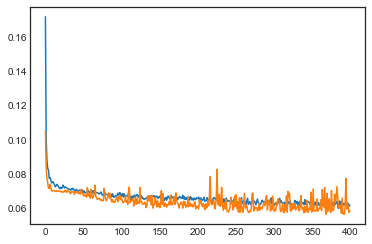

In [282]:
plt.plot(np.sqrt(fitter.history['loss']))
plt.plot(np.sqrt(fitter.history['val_loss']))

In [196]:
rmsle(model.predict(X_k_test.values).reshape(-1), y_k_test)

0.05871372522137134

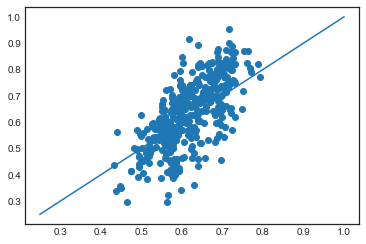

In [197]:
import matplotlib.pyplot as plt

plt.scatter(model.predict(X_k_test.values).reshape(-1), y_k_test)
plt.plot(np.linspace(.25,1,len(y_k_test)), np.linspace(.25,1,len(y_k_test)))

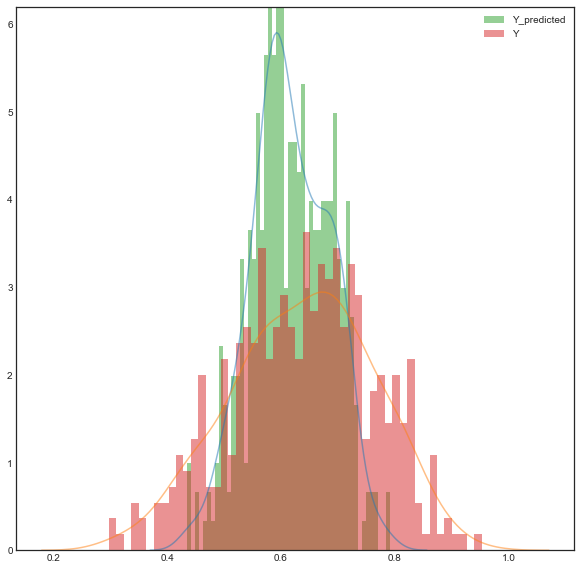

In [198]:
plt.figure(figsize=[10,10])

kdeplot(model.predict(X_k_test.values).reshape(-1), alpha=.5)
kdeplot(y_k_test.values,alpha=.5)

plt.hist(model.predict(X_k_test.values).reshape(-1), alpha=.5, normed=True,bins=50)
plt.hist(y_k_test,alpha=.5, normed=True,bins=50)
plt.legend(["Y_predicted", "Y"])

Now that we have several models with comparable accuracy we can try to improve our predictions with feature engineering.

# Feature Engineering

In [222]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
pol_feature = PolynomialFeatures(2)

g_reg = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=.05)

pipe_reg = Pipeline([("standardizer", scaler),
                     ("polynomial_feature_creation", pol_feature),
                     ("gradient_boosted_tree",g_reg)])
pipe_reg.fit(X_k_train, np.log(1+y_k_train))

Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial_feature_creation', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('gradient_boosted_tree', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
           ...s=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [223]:
rmsle(np.exp(pipe_reg.predict(X_k_test.values))-1, y_k_test)

0.04359965642135531

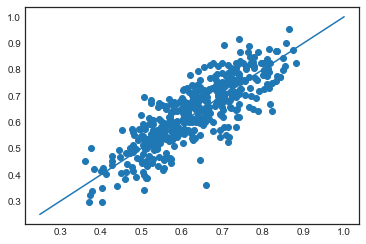

In [224]:
import matplotlib.pyplot as plt

plt.scatter(np.exp(pipe_reg.predict(X_k_test))-1, y_k_test)
plt.plot(np.linspace(.25,1,len(y_k_test)), np.linspace(.25,1,len(y_k_test)))

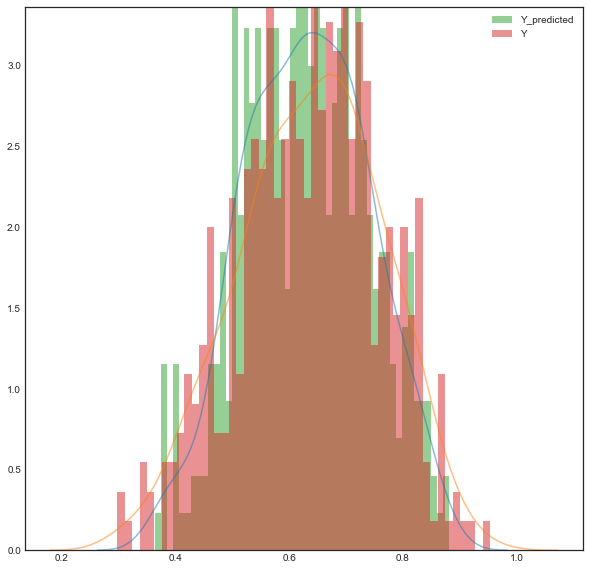

In [218]:
plt.figure(figsize=[10,10])

kdeplot(np.exp(pipe_reg.predict(X_k_test))-1, alpha=.5)
kdeplot(y_k_test.values,alpha=.5)

plt.hist(np.exp(pipe_reg.predict(X_k_test))-1, alpha=.5, normed=True,bins=50)
plt.hist(y_k_test,alpha=.5, normed=True,bins=50)
plt.legend(["Y_predicted", "Y"])

Now that we have a good model we can monitor which features are more important :

Text(0.5,1,u'Variable Importance')

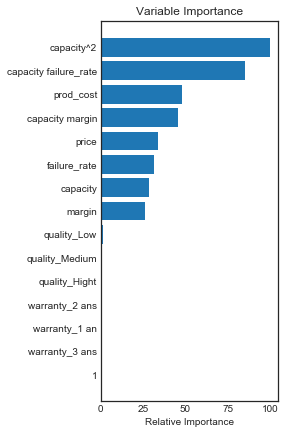

In [292]:
feature_name = np.array(pipe_reg.steps[1][1].get_feature_names(X_k.columns))
limit = 5
feature_importance = np.array(pipe_reg.named_steps['gradient_boosted_tree'].feature_importances_[:15])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=[7,7])
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

So the most useful features to predict are capacity squared, capacity \* failure rate, production costs, capacity \* margin and price. We do not apply feature engineering to the other models for different reasons :
- Gaussian processes suffer from the curse of dimensionality so it might be a bad idea to add too many artificial features.
- Neural Networks are supposed to do feature engineering "by themselves" so there is no need complicating features.